In [1]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout,GRU
from sklearn.model_selection import train_test_split
import re#regular expression
import numpy as np 
import pandas as pd
from nltk.corpus import stopwords
from nltk import word_tokenize
from tensorflow.keras import backend
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
import keras


Using TensorFlow backend.


### Getting info about my local GPU

In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
keras.backend.set_session(sess)

def _get_available_devices():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print( _get_available_devices())


df = pd.read_csv("consumer_complaints.csv")
print("\nDATAFRAME INFORMATION:\n")
print(df.info())


['/device:CPU:0', '/device:XLA_CPU:0']


/Users/armandoordoricadelatorre/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



DATAFRAME INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
date_received                   555957 non-null object
product                         555957 non-null object
sub_product                     397635 non-null object
issue                           555957 non-null object
sub_issue                       212622 non-null object
consumer_complaint_narrative    66806 non-null object
company_public_response         85124 non-null object
company                         555957 non-null object
state                           551070 non-null object
zipcode                         551452 non-null object
tags                            77959 non-null object
consumer_consent_provided       123458 non-null object
submitted_via                   555957 non-null object
date_sent_to_company            555957 non-null object
company_response_to_consumer    555957 non-null object
timely_response                 555957 non

### Notes
*  Two columns in dataset are used (product, consumer_complaint_narrative)
*  The purpose of the project is to categorize consumer complaints by product
*  Columns containing null values are not included in the dataframe.
* Prepaid card and credit card complaints are merged to remove noise

In [3]:

fields= ['product','consumer_complaint_narrative'] 
df=pd.read_csv('consumer_complaints.csv', usecols=fields)

df = df[pd.notnull(df['consumer_complaint_narrative'])]


for i in range(df.shape[0]):
    if (df.iloc[i]=="Prepaid card").any():
        df.iloc[i]="Credit card"
    if (df.iloc[i]=="Virtual currency").any():
        df.iloc[i]="Other financial service"  

print("\nPRODUCT VALUE COUNT:\n")
print(df["product"].value_counts())
print("\nDATAFRAME HEAD:\n")
print(df.head())
# -----------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------
# PREPROCESSING-1


/Users/armandoordoricadelatorre/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



PRODUCT VALUE COUNT:

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 8790
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64

DATAFRAME HEAD:

                product                       consumer_complaint_narrative
190126  Debt collection  XXXX has claimed I owe them {$27.00} for XXXX ...
190135    Consumer Loan  Due to inconsistencies in the amount owed that...
190155         Mortgage  In XX/XX/XXXX my wages that I earned at my job...
190207         Mortgage  I have an open and current mortgage with Chase...
190208         Mortgage  XXXX was submitted XX/XX/XXXX. At the time I s...


In [4]:
# ---------------------------------------------------------------------------------
STOPWORDS=stopwords.words('english')
stopwords_extra=['bank', 'america', 'x/xx/xxxx', '00']
STOPWORDS.extend(stopwords_extra)

remove_caracteres = re.compile('[^0-9a-z #+_]')
replace_espaco = re.compile('[/(){}\[\]\|@,;]')
df = df.reset_index(drop=True)



### Class names are in the range of 0-9 since GRU NN takes numerical values as input.

In [11]:

Y = pd.get_dummies(df["product"]).values
print("shape Y", Y.shape)



class_name = ["" for x in range(10)]
for i in range(100):
    for j in range(10):
        if(Y[i,j]==1):
            class_name[j]=df.iloc[i]['product']
np.save('class_name',class_name)            

## Shuffling the data to prevent the model from memorizing 

X, Y = shuffle(df['consumer_complaint_narrative'] , Y)

# 0.1 to avoid using the same data in train and test stages

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state = 42)


X_test.to_csv('X_test_before_tokenizer.csv', header=True)
# Data cleaning removing words, punctuation, characters that would not affect the classification.
def pre_processamento(text):
    text = text.lower()
    text = remove_caracteres.sub('', text)
    text = replace_espaco.sub(' ', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text



shape Y (66806, 10)


In [6]:
X_train = X_train.apply(pre_processamento)
X_test = X_test.apply(pre_processamento)


n_max_palavras = 5000
tamanho_maximo_sent = 250


In [7]:

tokenizer = Tokenizer(num_words=n_max_palavras, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['consumer_complaint_narrative'].values)
word_index = tokenizer.word_index
print(' %s tokens unicos.' % len(word_index))

 58113 tokens unicos.


In [8]:


X_train = tokenizer.texts_to_sequences(X_train.values)
X_train = pad_sequences(X_train, maxlen=tamanho_maximo_sent)
print("shape X_train", X_train.shape)

X_test = tokenizer.texts_to_sequences(X_test.values)
X_test = pad_sequences(X_test, maxlen=tamanho_maximo_sent)
print("shape X_test", X_test.shape)


np.save('X_test', X_test)
np.save('Y_test', Y_test)

# --------------------------------------------------------------------------------------
# TRAINING
# --------------------------------------------------------------------------------------
# There are two GRU (Gated Recurrent Units) NNs in our model with 100 nodes.# Epoch: 5
# Batch size: 128
# Dropout: 0.2
# Activation func: softmax
# Optimizer: Adam
# --------------------------------------------------------------------------------------

shape X_train (60125, 250)
shape X_test (6681, 250)


In [9]:
embedding_dimensions = 100
epochs = 5
batch_size = 512

model = Sequential()
model.add(Embedding(n_max_palavras, embedding_dimensions, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(GRU(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(100))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Fitting the model and generating accuracy and loss plots

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          500000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
gru (GRU)                    (None, 250, 100)          60300     
_________________________________________________________________
dropout (Dropout)            (None, 250, 100)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

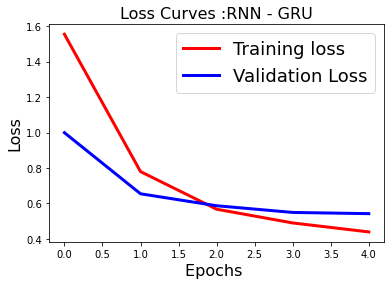


Accuracy: 83.42%


In [10]:
print(model.summary())
history=model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,shuffle=True)

# Saving the model that was used in testing stage
model.save('my_model.h5')


fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN - GRU',fontsize=16)
plt.show()

scores = model.evaluate(X_test, Y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))